This notebook creates and then trains naive templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/galaxy_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
# functions that define the templates
# chosen to separate out the different spectral shapes in the photometry
tf1 = lambda x: 0.1*np.exp(-1/90*(x-500)) + 0.2
tf2 = lambda x: -1.5/500*(x-400)+1.6
tf3 = lambda x: -1.1/500*(x-400)+1.3
tf4 = lambda x: 1/np.sqrt(200)*np.sqrt(abs(x-300))*(1-x/1000) + 0.6
tf5 = lambda x: 0.5*np.cos(np.pi/800*(x-300)) + 0.7
tf6 = lambda x: 1/4*(3/np.sqrt(200)*np.sqrt(abs(x-300))*(1-x/1000) + 1.8 + 0.5*np.cos(np.pi/800*(x-300)) + 0.7)
sig1 = 0.6
mu1 = 0.3
xscale1 = 450
tf7 = lambda x: 1/(x/xscale1*sig1)*np.exp(-(np.log(x/xscale1)-mu1)**2/(2*sig1**2))
tf8 = lambda x: 0.5/500*(x-400)+0.5
sig2 = 0.6
mu2 = 0.6
xscale2 = 500
tf9 = lambda x: 1/(x/xscale2*sig2)*np.exp(-(np.log(x/xscale2)-mu2)**2/(2*sig2**2))

template_functions = [tf1,tf2,tf3,tf4,tf5,tf6,tf7,tf8,tf9]

# save the templates as Seds
naive_templates = dict()
for i,tf in enumerate(template_functions):
    template = Sed()
    template.wavelen = np.linspace(10,2300,100)
    template.flambda = tf(template.wavelen)
    template.flambda = np.clip(template.flambda,a_min=0,a_max=None)
    template.wavelen *= 10
    naive_templates["naive"+str(i+1)] = template

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(naive_templates,galaxies,bandpass_dict)

CPU times: user 56.8 s, sys: 54.7 ms, total: 56.8 s
Wall time: 57 s


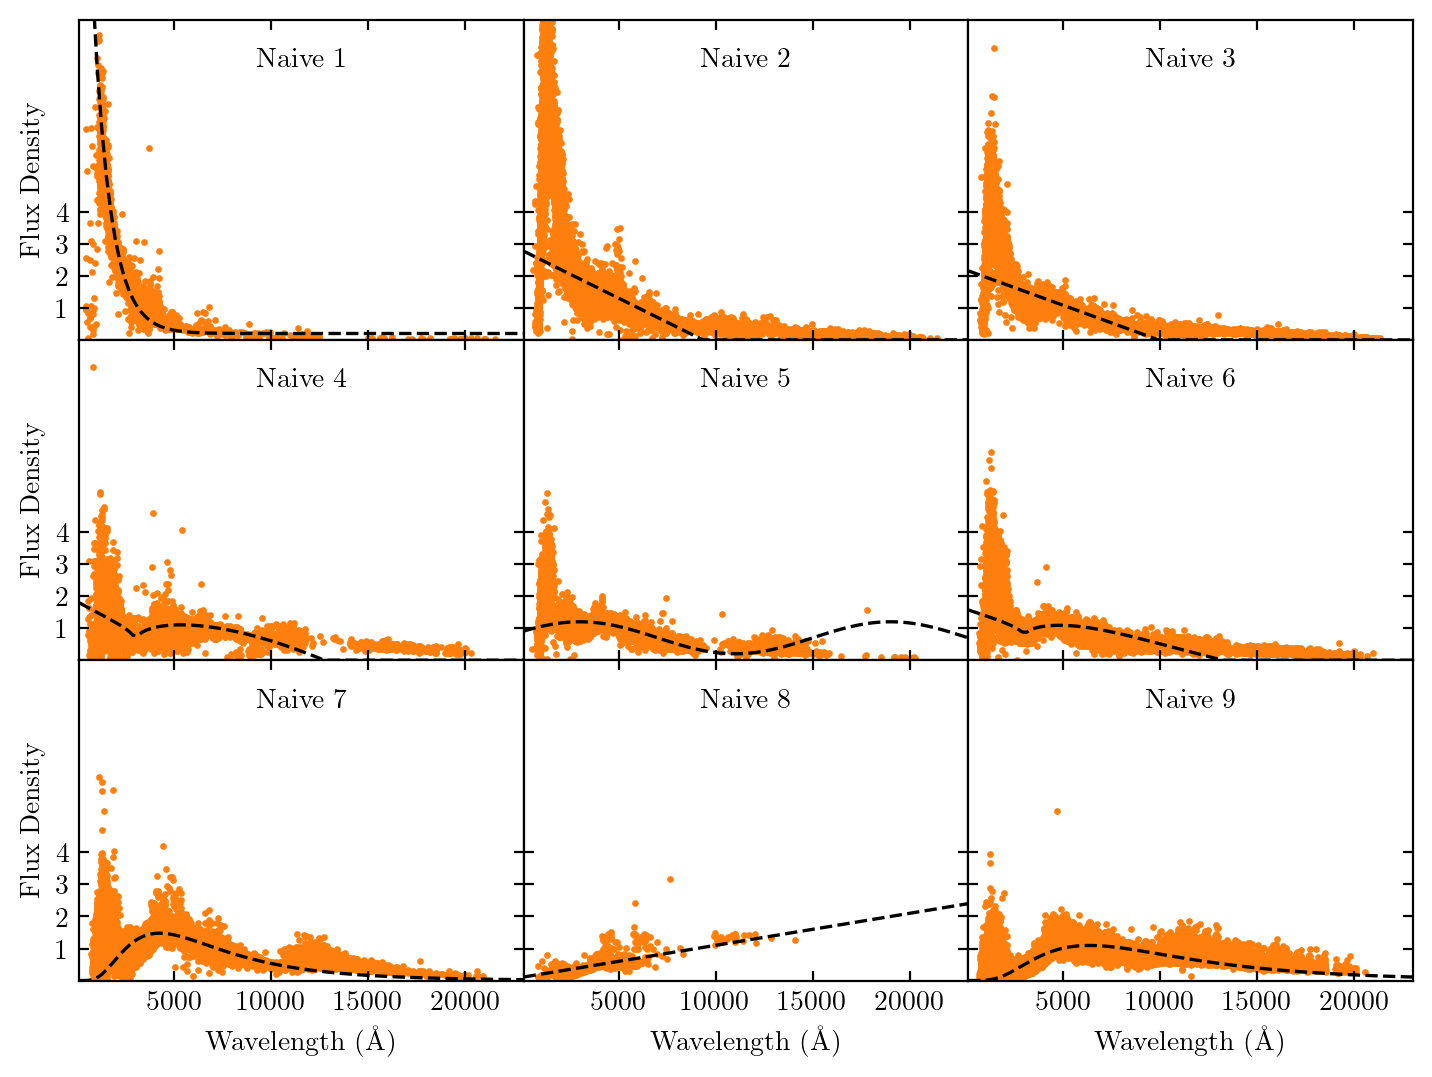

In [7]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,sharex='all',sharey='all',figsize=(twocol,0.75*twocol))

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
for i,ax in enumerate(axes):
    
    wavelen = [row[0] for row in training_sets["naive"+str(i+1)]]
    fluxes = [row[1] for row in training_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = naive_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
    ax.set_yticks([1,2,3,4])
    #ax.set_xticks([2500,5000,7500,9800])
    #ax.set_xticklabels([2500,5000,7500,10000])

plt.xlim(100,23000)
plt.ylim(0,10)
ax7.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax8.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax9.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax1.set_ylabel('Flux Density')
ax4.set_ylabel('Flux Density')
ax7.set_ylabel('Flux Density')

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/naive_untrained.pdf')

Now train the templates

In [8]:
%%time
trained_templates, final_sets = train_templates(naive_templates, galaxies, bandpass_dict, N_iter=1, w=0.75)

Round 1/5
0.011505380452488407
0.002663034747097457
0.002702621219243846
0.0036194938022081537
0.0032287228739415023
0.0022711592974755334
0.0032481957556777918
0.0064153894992078145
0.003108849834520416
Round 2/5
0.011064170876025212
0.003523981690277479
0.002204741282600676
0.004568745348445233
0.003114064899605026
0.0023245008828881187
0.0033278182234262182
0.0056268173105590066
0.0032953376781414833
Round 3/5
0.009578928939916662
0.0038863861386971227
0.002089428409977148
0.004956329093618955
0.0031782093484802472
0.0022664993273755546
0.003347992788796248
0.005893848832510067
0.0035835899155519375
Round 4/5
0.008144045919860397
0.0042457249449477565
0.0020170635132905
0.005271539126176696
0.0029541062637333
0.0023154503851695804
0.0031624515286204865
0.006249809898436837
0.0035150769862330633
Round 5/5
0.007490747555337243
0.004335027160319658
0.002032387605026375
0.005477944218104063
0.002841911183142317
0.002366760427609338
0.0032877198563261907
0.006449330557304025
0.0035436796

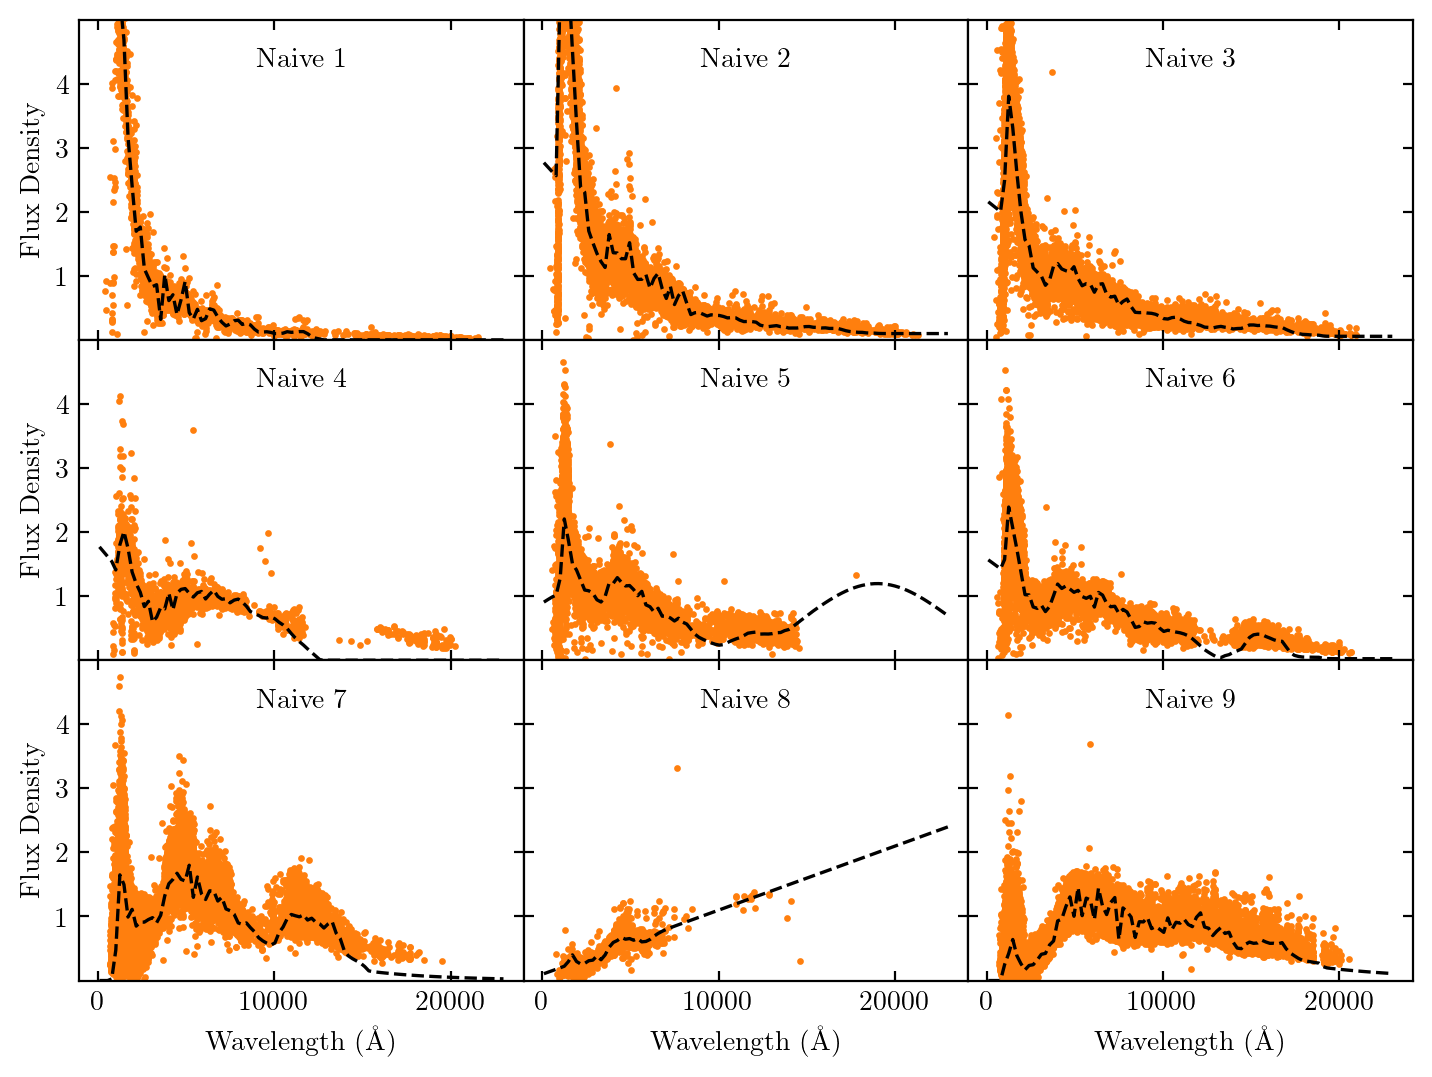

In [9]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,sharex='all',sharey='all',figsize=(twocol,0.75*twocol))

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for i,ax in enumerate(axes):
    
    wavelen = [row[0] for row in final_sets["naive"+str(i+1)]]
    fluxes = [row[1] for row in final_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
    ax.set_yticks([1,2,3,4])

#plt.xlim(500,11200)
plt.ylim(0,5)
ax7.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax8.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax9.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax1.set_ylabel('Flux Density')
ax4.set_ylabel('Flux Density')
ax7.set_ylabel('Flux Density')

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
#fig.savefig('plots/naive_trained.pdf')

Save the results!

In [10]:
for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = trained_templates[template].wavelen
    y = trained_templates[template].flambda
    for i in range(len(x)):
        file.write("{0:<10.2f}{1:<10.2f}\n".format(x[i],y[i]))
    file.close()

Plot the naive templates with the CWW+SB4 Templates

In [11]:
cwwsb4 = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 
                'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']

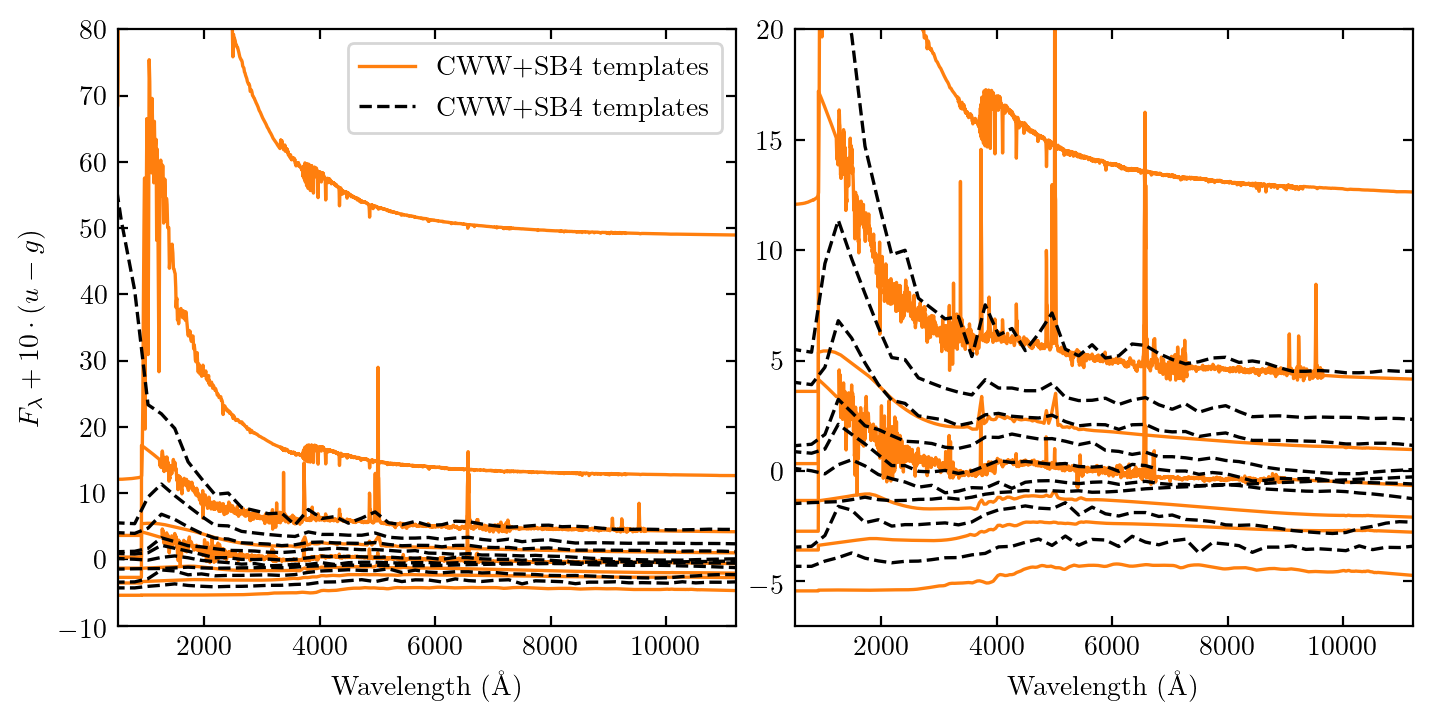

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(twocol,twocol/2))

colors = ['C1','k']
styles = ['-','--']
titles = ['CWW+SB4 templates', "Naive templates"]
for i,template_set in enumerate([cwwsb4,trained_templates]):

    for template in template_set:
        name = 'templates/'+template+'.sed'
        x,y = np.loadtxt(name,unpack=True)
        f = interp1d(x,y)
        y /= f(8000)

        sed = Sed()
        sed.wavelen = x
        sed.flambda = y

        u = sed.flux(bandpass_dict['u'])
        g = sed.flux(bandpass_dict['g'])
        template_fluxes = sed.fluxlist(bandpass_dict)
        
        ax1.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])
        ax2.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])

ax1.plot([5000],[30],c='C1',label='CWW+SB4 templates')
ax1.plot([5000],[30],c='k',ls='--',label='CWW+SB4 templates')
ax1.legend()

ax1.set_ylim(-10,80)
ax1.set_xlim(500,11200)
ax1.set_ylabel('$F_\lambda + 10 \cdot (u-g)$') 
ax1.set_xlabel('Wavelength ($\mathrm{\AA}$)')

ax2.set_ylim(-7,20)
ax2.set_xlim(500,11200)
ax2.set_xlabel('Wavelength ($\mathrm{\AA}$)')

fig.tight_layout(pad=0.5)
#fig.savefig("plots/naive_vs_cwwsb4.pdf")
plt.show()